## Data collection toolkit for monitoring "peer effects"

This cell sets up the notebook to import numpy, datetime, seaborn, pandas, matplotlib etc.

In [1]:
# Run this cell to set up the notebook.

# These lines import the Numpy, Datascience, pandas modules.
import numpy as np
import pandas as pd
import seaborn as sns
import random
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt

# Importing plotting libraries and styles
%matplotlib inline
plt.style.use('fivethirtyeight')

# For Pandas to ignore FutureWarning displays
import warnings
warnings.simplefilter('ignore', FutureWarning)

## Creating some plots

In [39]:
departureData = pd.read_csv("run_500_v3_departures.csv")
departureData = np.asarray(departureData["0"])
depDiff = 2242.9414892678574

95% Confidence Interval is (2332.9345732599327, 2690.628927247768)
Observed value (in actual pairs) is 2242.9414892678574


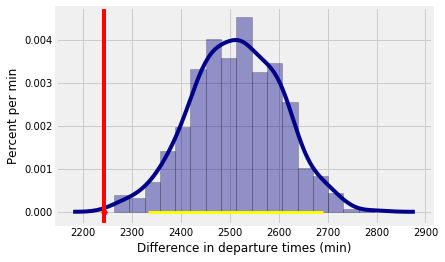

In [46]:
sns.distplot(departureData, hist=True, kde=True, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

left = np.percentile(departureData, 2.5)
right = np.percentile(departureData, 97.5)
print("95% Confidence Interval is", (left, right))
print("Observed value (in actual pairs) is", depDiff)

#plt.hist(test_stats)
plt.plot([left, right], [0, 0], color='yellow', lw=3, zorder=1)

# Observed value statistic on actual_pairs
plt.scatter(depDiff, 0, color='red', s=30, zorder=2)
plt.axvline(x=depDiff, color='red')

# Formatting
plt.xlabel('Difference in departure times (min)')
plt.ylabel('Percent per min')
#plt.title('Side-by-Side Histogram with Multiple Airlines')
plt.savefig('departures.pdf', bbox_inches='tight')

In [47]:
arrivalData = pd.read_csv("run_500_v2_arrivals.csv")
arrivalData = np.asarray(arrivalData["0"])
arrivalDiff = 2323.4998120806454

95% Confidence Interval is (2068.4409434241134, 2406.5036085220972)
Observed value (in actual pairs) is 2323.4998120806454


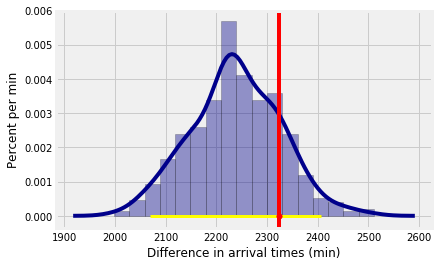

In [50]:
sns.distplot(arrivalData, hist=True, kde=True, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

left = np.percentile(arrivalData, 2.5)
right = np.percentile(arrivalData, 97.5)
print("95% Confidence Interval is", (left, right))
print("Observed value (in actual pairs) is", arrivalDiff)

#plt.hist(test_stats)
plt.plot([left, right], [0, 0], color='yellow', lw=3, zorder=1)

# Observed value statistic on actual_pairs
plt.scatter(arrivalDiff, 0, color='red', s=30, zorder=2)
plt.axvline(x=arrivalDiff, color='red')

# Formatting
plt.xlabel('Difference in arrival times (min)')
plt.ylabel('Percent per min')
#plt.title('Side-by-Side Histogram with Multiple Airlines')
plt.savefig('arrivals.pdf', bbox_inches='tight')

Defining the class `Person`

In [38]:
class Person:
    def __init__(self, identity, index, startTime, neighbors, fromStart):
        self.identity = identity
        self.index = index
        self.startTime = startTime
        self.breakStart = []
        self.breakEnd = []
        self.fromStart = int(fromStart)
        self.endTime = None
        self.tillEnd = 0
        self.neighbors = neighbors
        self.known = []
    
    def addBreak(self, time):
        self.breakStart.append(time)
        return "Break started for person " + str(self.index) + " at " + str(time)
    
    def endBreak(self, time):
        if (len(self.breakStart)-1)!=len(self.breakEnd):
            return "Please start a break to stop it."
        else:
            self.breakEnd.append(time)
            return "Break ended for person " + str(self.index) + " at " + str(time)
        
    def endSession(self, time):
        self.endTime = time
        return "Person " + str(self.index) + " left at " + str(time)
        
    def numBreaks(self):
        return len(self.breakEnd)
    
    def getNeighbors(self):
        return self.neighbors
    
    def addNeighbor(self, number, identity):
        self.neighbors.append((number, identity))
        
    def setTillEnd(self, time):
        self.endTime = time
        self.tillEnd = 1
    
    def addKnown(self, lst):
        for i in lst:
            print(self.index, "knows", i[0])
        self.known.extend(lst)

Defining the class `Table`

In [3]:
class Table:
    listTables = dict()
    usedID = pd.read_csv('usedID.csv')
    
    def __init__(self, name, libraryName = ''):
        if (not isinstance(name, str)):
            print("ERROR: Table name should be a string")
            return
        if (not isinstance(libraryName, str)):
            print("ERROR: Table name should be a string")
            return
        self.name = name
        self.startTime = dt.datetime.now()
        self.library = libraryName
        
        # Dictionary of current active persons on Table (Number -> Person Object)
        self.currentPersons = dict()
        
        # List of Person Objects which have ever sat at Table
        self.allPersons = []
        
        Table.listTables[name] = self
        print("Table with name " + str(name) + " created at time: " + str(self.startTime))
        
    def addPerson(self, number, fromTheStart = False):
        if (not isinstance(number, int)):
            print("ERROR: Please give a number as person index")
            return
        if (not isinstance(fromTheStart, bool)):
            print("ERROR: Third argument should be True/False (person sitting from the start or not)")
            return
        if number in self.currentPersons:
            print("ERROR: Person already exists on Table: " + self.name)
            return
        
        iden = random.randint(0,10000)
        while iden in set(self.usedID):
            iden = random.randint(0,10000)
        
        # Neighbors: A list of numbers
        neighbors = [(key, self.currentPersons[key].identity) for key in self.currentPersons]
        
        # Adding current number as a neighbor to already existing neighbors
        for aPerson in self.currentPersons:
            self.currentPersons[aPerson].addNeighbor(number, iden)
            
        # Creating Person object for this person
        newPerson = Person(iden, number, dt.datetime.now(), neighbors, int(fromTheStart))
        self.usedID.loc[len(self.usedID)] = [iden]
        self.currentPersons[number] = newPerson
        self.allPersons.append(newPerson)
        
        print("Person number " + str(number) + " added to Table " + str(self.name))
        return
    
    def addBreak(self, number):
        if (not isinstance(number, int)):
            print("ERROR: Please give a number as person index")
            return
        if number not in self.currentPersons:
            print("ERROR: Person " + str(number) + " not in list of active people on Table " + self.getName())
            return
        person = self.currentPersons[number]
        time = dt.datetime.now()
        print(person.addBreak(time))
        
    def getName(self):
        return self.name
        
    def endBreak(self, number):
        if (not isinstance(number, int)):
            print("ERROR: Please give a number as person index")
            return
        if number not in self.currentPersons:
            print("ERROR: Person " + str(number) + " not in list of people.")
            return
        time = dt.datetime.now()
        person = self.currentPersons[number]
        print(person.endBreak(time))
        
    def removePerson(self, number):
        if (not isinstance(number, int)):
            print("ERROR: Please give a number as person index")
            return
        if number not in self.currentPersons:
            print("This person doesn't exist and so, can't be removed")
            return
        else:
            person = self.currentPersons.pop(number)
            time = dt.datetime.now()
            print(person.endSession(time))
            return
    
    def getNumBreaks(self, number):
        if (not isinstance(number, int)):
            print("ERROR: Please give a number as person index")
            return
        if number not in self.currentPersons:
            print("ERROR: Person not active on Table")
            return
        person = self.currentPersons[number]
        print("Person " + str(number) + " has taken " + str(person.numBreaks()) + " breaks.")
        return
    
    def getCurrentPersons(self):
        return self.currentPersons
    
    def known(self, person, lst):
        # lst is a list of numbers in the currentPersons, we should get their ID as well
        # eg. B.known(1, [2,5]) => Known for 1 should be [(2, ID(2)), (5, ID(5))]
        
        personObj = self.currentPersons[person]
        personObj.addKnown([(i, self.currentPersons[i].identity) for i in lst])
        for otherPerson in lst:
            otherPersonObj = self.currentPersons[otherPerson]
            otherPersonObj.addKnown([(person, personObj.identity)])

Creating the `convertToRow` function for appending to Dataframe

In [4]:
def convertToRow(person, table):
    row = [person.identity, person.index, table.name, table.library, person.startTime, \
           person.endTime, person.numBreaks(), person.breakStart, person.breakEnd, person.fromStart, person.tillEnd, person.getNeighbors(), person.known, yourName, yourTable, str(yourSeat)]
    return row

The function `showTables` shows all the active Tables and active Seats on that table

In [5]:
def showTables():
    for table in Table.listTables.values():
        seatsTaken = table.getCurrentPersons().keys()
        print("Table Name: " + table.getName() + ", " + "Current seats taken: " + " ".join(str(e) for e in seatsTaken))

Run the function `quitSession` when you (the **Data Collector** want to leave)

In [6]:
def quitSession():
    time = dt.datetime.now()
    for table in Table.listTables.values():
        for person in table.currentPersons.values():
            person.setTillEnd(time)
    print("You left at", time)

## Extended Demo

In [7]:
# The code below creates a new table named A in Moffit Library
A = Table("A", "Moffit")

Table with name A created at time: 2019-03-23 18:20:02.240387


In [8]:
# Adds person at Seats 2,5 to Table A

A.addPerson(2)

A.addPerson(5)

# Trying to add Person 2 again
A.addPerson(2)

Person number 2 added to Table A
Person number 5 added to Table A
ERROR: Person already exists on Table: A


In [9]:
# Person 5 on Table A leaves for a break

A.addBreak(5)

Break started for person 5 at 2019-03-23 18:20:03.078134


In [10]:
# Similarly, creating Table B at Main Stacks

B = Table("B", "Stacks")

Table with name B created at time: 2019-03-23 18:21:40.452316


Adding person at Seat 1, Table B, but he was already there from the start. **Note:** Adding True as the second argument implies that the person was there before you came in.

In [11]:
#Adding person at Seat 1, Table B, but he was already there from the start.

B.addPerson(1, True)

Person number 1 added to Table B


In [12]:
# Another person comes in and sits down at Seat 3, Table B.

B.addPerson(3)

Person number 3 added to Table B


In [13]:
# Person 1 and 3 on Table B leave together for a break

B.addBreak(1)

B.addBreak(3)

Break started for person 1 at 2019-03-23 18:27:36.356506
Break started for person 3 at 2019-03-23 18:27:36.356672


In [14]:
# 2 never left for a break
A.endBreak(2)

# But 5 did, so we can end his break.
A.endBreak(5)

Please start a break to stop it.
Break ended for person 5 at 2019-03-23 18:30:23.076207


In [15]:
# Person 2 on Table A departs for the day

A.removePerson(2)

Person 2 left at 2019-03-23 18:33:47.097748


In [16]:
# Trying to remove Person 2 again.
A.removePerson(2)

This person doesn't exist and so, can't be removed


In [17]:
# Showing all the Seats that are currently active

showTables()

Table Name: A, Current seats taken: 5
Table Name: B, Current seats taken: 1 3


In [18]:
B.addPerson(6)

Person number 6 added to Table B


In [19]:
# Let us suppose that Person 1 on B knows Person 3 on B

B.known(1, [3, 6])

1 knows 3
1 knows 6
3 knows 1
6 knows 1


In [20]:
# Removing Person 1 from Table B
B.endBreak(1)
B.endBreak(3)
A.addBreak(5)

B.removePerson(1)

Break ended for person 1 at 2019-03-23 18:37:07.846518
Break ended for person 3 at 2019-03-23 18:37:07.846609
Break started for person 5 at 2019-03-23 18:37:07.846659
Person 1 left at 2019-03-23 18:37:07.846707


In [21]:
# Add break for Person 3
B.addBreak(3)

# Again, showing active seats
showTables()

Break started for person 3 at 2019-03-23 18:37:39.406687
Table Name: A, Current seats taken: 5
Table Name: B, Current seats taken: 3 6


In [25]:
# Ending break for Person 3
B.endBreak(3)

# Suppose I want to leave the library now, I simply run
quitSession()

Break ended for person 3 at 2019-03-23 17:50:45.553422
You left at 2019-03-23 17:50:45.553800


## Start writing your code below to add Tables

In [26]:
# Fill in this cell with your information, for example:
yourName = "Max"
yourTable = "B"
yourSeat = 2

### Important (Read me)
1. Run the cell below to update the libData.csv file!

**Format:** Person, Table, Library, Arrival Time, Departure Time, Num Breaks, Break Start Times (list), Break End Times (list), fromStart, tillEnd, Neighbours

In [27]:
# RUN THIS CELL AT THE END, then close this tab!

# This automatically adds data that we've input into the libData.csv dataframe
df = pd.read_csv('libData.csv')
for table in Table.listTables.values():
    for person in table.allPersons:
        df = df.append(pd.DataFrame([convertToRow(person, table)],columns=df.columns))
Table.usedID.to_csv('usedID.csv', index=False)
df.to_csv('libData.csv', index=False)